In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio

from scipy.stats import pearsonr, spearmanr

import operator
import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter
from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.collections as collections

import isolearn.io as isoio


In [2]:
#Load predictions

pred_df = pd.read_csv("predictions/apa_segal_data/segal_variants_predictions_df_deerect_apa.csv", sep='\t')

pred_df['Pred_Expression'] = pred_df['logodds_pred']


In [3]:
#Load auxiliary train/test dataframe

pred_df_train_test = pd.read_csv("../data/native_data/segal_variants_train_test.tab", sep='\t')[['ID', 'Fold']]
pred_df = pred_df.join(pred_df_train_test.set_index("ID"), on="ID", how='left')

#Filter data

pred_df['Artifact'] = pred_df['Sequence'].apply(lambda x: "AAAAAAAAAA" in x)
pred_df['Artifact'] = (pred_df['Artifact'] | pred_df['Sequence'].apply(lambda x: x[41:44] == 'AGA'))
pred_df['Artifact'] = (pred_df['Artifact'] | np.isnan(pred_df['Expression']))

#pred_df = pred_df.query("Artifact == False and Fold == 'Test'")
pred_df = pred_df.query("Artifact == False")

pred_df_test = pred_df.query("Fold == 'Test'").copy().reset_index(drop=True)

#Load scanning mutagenesis dataframe

scan_df = pd.read_csv("../data/native_data/segal_variants_scanning_muta.tab", sep='\t')[['ID', 'PAS', 'Pos']]
scan_df = pred_df.join(scan_df.set_index("ID"), on="ID", how="inner").copy().reset_index(drop=True)

scan_df_wt = scan_df.query("Pos == 'WT'").copy().reset_index(drop=True)

scan_df_var = scan_df.query("Pos != 'WT'").copy().reset_index(drop=True)
scan_df_var = scan_df_var.join(scan_df_wt.set_index("PAS"), on="PAS", how='inner', rsuffix='_WT')

scan_df_var['Delta_Fold_Change'] = scan_df_var['Expression'] - scan_df_var['Expression_WT']
scan_df_var['Pred_Delta_Fold_Change'] = scan_df_var['Pred_Expression'] - scan_df_var['Pred_Expression_WT']

#Filter out artifact sequences
scan_df_var = scan_df_var.query("Pos != '41:60'").copy().reset_index(drop=True)

scan_df_var_test = scan_df_var.query("Fold == 'Test'").copy().reset_index(drop=True)


/home/jlinder2/anaconda3/envs/tensorflow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


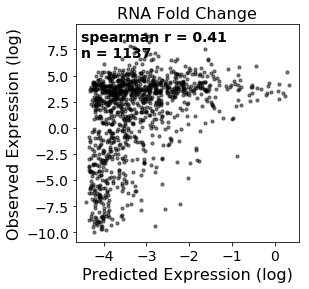

In [4]:

save_figs = True

pearson_r_val, _ = pearsonr(pred_df_test['Pred_Expression'], pred_df_test['Expression'])
spearman_r_val, _ = spearmanr(pred_df_test['Pred_Expression'], pred_df_test['Expression'])

f = plt.figure(figsize=(4, 4))

plt.scatter(pred_df_test['Pred_Expression'], pred_df_test['Expression'], alpha=0.5, s=10, c='black')

annot_text = 'spearman r = ' + str(round(spearman_r_val, 2))
annot_text += '\nn = ' + str(len(pred_df_test))
ax = plt.gca()
ax.text(0.025, 0.975, annot_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=14, weight="bold")

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

#plt.xlim(-5., 2.5)

plt.xlabel('Predicted Expression (log)', fontsize=16)
plt.ylabel('Observed Expression (log)', fontsize=16)
plt.title('RNA Fold Change', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('segal_expression_pred_deerect_apa.png', dpi=150, transparent=True)
    plt.savefig('segal_expression_pred_deerect_apa.eps')

plt.show()


In [5]:
#HIV UTR

ref_id = 43141
var_ids = [k for k in range(31148, 31192+1)]

pred_df_var = pred_df.loc[pred_df['ID'].isin(var_ids)].copy().reset_index(drop=True)

pred_df_var['Delta_Fold_Change'] = pred_df_var['Expression'] - pred_df.query("ID == " + str(ref_id)).iloc[0]['Expression']
pred_df_var['Pred_Delta_Fold_Change'] = pred_df_var['Pred_Expression'] - pred_df.query("ID == " + str(ref_id)).iloc[0]['Pred_Expression']

pred_df_var_train = pred_df_var.query("Fold != 'Test'").copy().reset_index(drop=True)
pred_df_var_test = pred_df_var.query("Fold == 'Test'").copy().reset_index(drop=True)


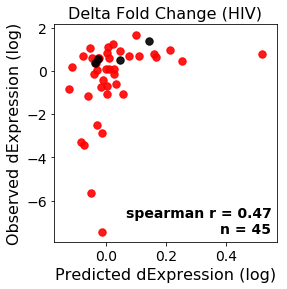

In [6]:

utr_name = 'HIV'

save_figs = True

pearson_r_val, _ = pearsonr(pred_df_var['Pred_Delta_Fold_Change'], pred_df_var['Delta_Fold_Change'])
spearman_r_val, _ = spearmanr(pred_df_var['Pred_Delta_Fold_Change'], pred_df_var['Delta_Fold_Change'])

f = plt.figure(figsize=(4, 4))

plt.scatter(pred_df_var_train['Pred_Delta_Fold_Change'], pred_df_var_train['Delta_Fold_Change'], alpha=0.9, s=55, c='red')
plt.scatter(pred_df_var_test['Pred_Delta_Fold_Change'], pred_df_var_test['Delta_Fold_Change'], alpha=0.9, s=55, c='black')

annot_text = 'spearman r = ' + str(round(spearman_r_val, 2))
annot_text += '\nn = ' + str(len(pred_df_var))
ax = plt.gca()
ax.text(0.975, 0.025, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=14, weight="bold")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted dExpression (log)', fontsize=16)
plt.ylabel('Observed dExpression (log)', fontsize=16)
plt.title('Delta Fold Change (' + utr_name + ')', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('segal_delta_expression_pred_deerect_apa_' + utr_name + '.png', dpi=150, transparent=True)
    plt.savefig('segal_delta_expression_pred_deerect_apa_' + utr_name + '.eps')

plt.show()


In [7]:
#SVL

ref_id = 43180
var_ids = [k for k in range(31103, 31147+1)]

pred_df_var = pred_df.loc[pred_df['ID'].isin(var_ids)].copy().reset_index(drop=True)

pred_df_var['Delta_Fold_Change'] = pred_df_var['Expression'] - pred_df.query("ID == " + str(ref_id)).iloc[0]['Expression']
pred_df_var['Pred_Delta_Fold_Change'] = pred_df_var['Pred_Expression'] - pred_df.query("ID == " + str(ref_id)).iloc[0]['Pred_Expression']

pred_df_var_train = pred_df_var.query("Fold != 'Test'").copy().reset_index(drop=True)
pred_df_var_test = pred_df_var.query("Fold == 'Test'").copy().reset_index(drop=True)


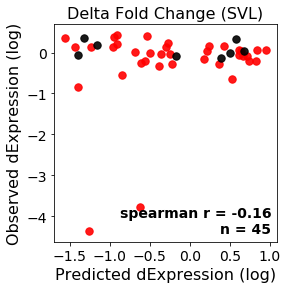

In [8]:

utr_name = 'SVL'

save_figs = True

pearson_r_val, _ = pearsonr(pred_df_var['Pred_Delta_Fold_Change'], pred_df_var['Delta_Fold_Change'])
spearman_r_val, _ = spearmanr(pred_df_var['Pred_Delta_Fold_Change'], pred_df_var['Delta_Fold_Change'])

f = plt.figure(figsize=(4, 4))

plt.scatter(pred_df_var_train['Pred_Delta_Fold_Change'], pred_df_var_train['Delta_Fold_Change'], alpha=0.9, s=55, c='red')
plt.scatter(pred_df_var_test['Pred_Delta_Fold_Change'], pred_df_var_test['Delta_Fold_Change'], alpha=0.9, s=55, c='black')

annot_text = 'spearman r = ' + str(round(spearman_r_val, 2))
annot_text += '\nn = ' + str(len(pred_df_var))
ax = plt.gca()
ax.text(0.975, 0.025, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=14, weight="bold")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted dExpression (log)', fontsize=16)
plt.ylabel('Observed dExpression (log)', fontsize=16)
plt.title('Delta Fold Change (' + utr_name + ')', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('segal_delta_expression_pred_deerect_apa_' + utr_name + '.png', dpi=150, transparent=True)
    plt.savefig('segal_delta_expression_pred_deerect_apa_' + utr_name + '.eps')

plt.show()


In [9]:
#SPA1

ref_id = 43159
var_ids = [k for k in range(31058, 31102+1)]

pred_df_var = pred_df.loc[pred_df['ID'].isin(var_ids)].copy().reset_index(drop=True)

pred_df_var['Delta_Fold_Change'] = pred_df_var['Expression'] - pred_df.query("ID == " + str(ref_id)).iloc[0]['Expression']
pred_df_var['Pred_Delta_Fold_Change'] = pred_df_var['Pred_Expression'] - pred_df.query("ID == " + str(ref_id)).iloc[0]['Pred_Expression']

pred_df_var_train = pred_df_var.query("Fold != 'Test'").copy().reset_index(drop=True)
pred_df_var_test = pred_df_var.query("Fold == 'Test'").copy().reset_index(drop=True)


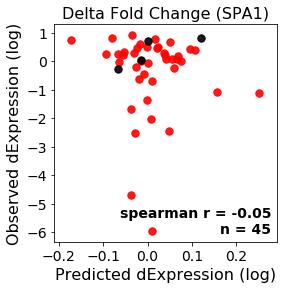

In [10]:

utr_name = 'SPA1'

save_figs = True

pearson_r_val, _ = pearsonr(pred_df_var['Pred_Delta_Fold_Change'], pred_df_var['Delta_Fold_Change'])
spearman_r_val, _ = spearmanr(pred_df_var['Pred_Delta_Fold_Change'], pred_df_var['Delta_Fold_Change'])

f = plt.figure(figsize=(4, 4))

plt.scatter(pred_df_var_train['Pred_Delta_Fold_Change'], pred_df_var_train['Delta_Fold_Change'], alpha=0.9, s=55, c='red')
plt.scatter(pred_df_var_test['Pred_Delta_Fold_Change'], pred_df_var_test['Delta_Fold_Change'], alpha=0.9, s=55, c='black')

annot_text = 'spearman r = ' + str(round(spearman_r_val, 2))
annot_text += '\nn = ' + str(len(pred_df_var))
ax = plt.gca()
ax.text(0.975, 0.025, annot_text, horizontalalignment='right', verticalalignment='bottom', transform=ax.transAxes, color='black', fontsize=14, weight="bold")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted dExpression (log)', fontsize=16)
plt.ylabel('Observed dExpression (log)', fontsize=16)
plt.title('Delta Fold Change (' + utr_name + ')', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('segal_delta_expression_pred_deerect_apa_' + utr_name + '.png', dpi=150, transparent=True)
    plt.savefig('segal_delta_expression_pred_deerect_apa_' + utr_name + '.eps')

plt.show()


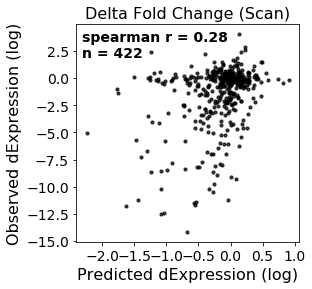

In [11]:

save_figs = True

pearson_r_val, _ = pearsonr(scan_df_var_test['Pred_Delta_Fold_Change'], scan_df_var_test['Delta_Fold_Change'])
spearman_r_val, _ = spearmanr(scan_df_var_test['Pred_Delta_Fold_Change'], scan_df_var_test['Delta_Fold_Change'])

f = plt.figure(figsize=(4, 4))

plt.scatter(scan_df_var_test['Pred_Delta_Fold_Change'], scan_df_var_test['Delta_Fold_Change'], alpha=0.75, s=10, c='black')

annot_text = 'spearman r = ' + str(round(spearman_r_val, 2))
annot_text += '\nn = ' + str(len(scan_df_var_test))
ax = plt.gca()
ax.text(0.025, 0.975, annot_text, horizontalalignment='left', verticalalignment='top', transform=ax.transAxes, color='black', fontsize=14, weight="bold")


plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Predicted dExpression (log)', fontsize=16)
plt.ylabel('Observed dExpression (log)', fontsize=16)
plt.title('Delta Fold Change (Scan)', fontsize=16)

#plt.tight_layout()

if save_figs :
    plt.savefig('segal_delta_expression_pred_deerect_apa_scan.png', dpi=150, transparent=True)
    plt.savefig('segal_delta_expression_pred_deerect_apa_scan.eps')

plt.show()
